<a href="https://colab.research.google.com/github/chorltonm/fa-cup-upsets/blob/main/notebooks/models/rating_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# Import Libaries
import os
import sys
import json
import pandas as pd
import numpy as np
import importlib
import pandas_gbq


from google.cloud import bigquery
from google.oauth2 import service_account
from google.colab import drive
from google.colab import userdata

# Install scikit learn
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [11]:
# Install Trueskill library
!pip install trueskill
from trueskill import Rating, rate_1vs1

In [12]:
# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/python_files')


# Import user defined python functions
import model_evaluation_functions
import ratings_functions
importlib.reload(model_evaluation_functions)
importlib.reload(ratings_functions)

from ratings_functions import *
from model_evaluation_functions import *


Mounted at /content/drive


In [13]:
# Authentication credentials and keys

# Google Service Account

# Load the JSON key from local Google Collab file
key = json.load(open('/content/drive/MyDrive/service_account.json', 'r'))

# Authenticate using the loaded key
credentials = service_account.Credentials.from_service_account_info(key)

# Set up the BigQuery client with the credentials to project
client = bigquery.Client(credentials=credentials, project='birkbeck-msc-project-422917')

In [14]:
def load_predictions_and_ratings_to_bigquery(client, predictions_df, fold_ratings_df, ratings_model):

  # Load predictions to Big Query
  # Specify the target table
  load_dataset_name = 'analysis_layer'
  load_table_name = 'ratings_predictions'
  load_table_ref = f"{load_dataset_name}.{load_table_name}"

  # Delete predicitons method already inserted
  delete_query = f"DELETE FROM `{load_dataset_name}.{load_table_name}` WHERE ratings_model = '{ratings_model}'"
  delete_job = client.query(delete_query)
  delete_result = delete_job.result()
  predictions_total_rows_deleted = delete_result.num_dml_affected_rows
  print(f"Big Query target predictions table {load_dataset_name}.{load_table_name} rows deleted: {predictions_total_rows_deleted}")

  # Insert predictions for ratings model data to the existing table
  job_config = bigquery.LoadJobConfig(
          write_disposition="WRITE_APPEND")
  load_job = client.load_table_from_dataframe(
          predictions_df, load_table_ref, job_config=job_config)
  # Wait for the job to complete
  load_job.result()
  predictions_num_rows_inserted = load_job.output_rows
  print(f"{predictions_num_rows_inserted} rows appended to predictions table {load_table_ref} successfully.")

  # Load fold ratings to Big Query

  # Specify the target table
  load_dataset_name = 'analysis_layer'
  load_table_name = 'ratings'
  load_table_ref = f"{load_dataset_name}.{load_table_name}"

  # Delete ratings method already inserted
  delete_query = f"DELETE FROM `{load_dataset_name}.{load_table_name}` WHERE ratings_model = '{ratings_model}'"
  delete_job = client.query(delete_query)
  delete_result = delete_job.result()
  ratings_total_rows_deleted = delete_result.num_dml_affected_rows
  print(f"Big Query target ratings table {load_dataset_name}.{load_table_name} rows deleted: {ratings_total_rows_deleted}")


  # Insert ratings for ratings model data to the existing table
  job_config = bigquery.LoadJobConfig(
          write_disposition="WRITE_APPEND")
  load_job = client.load_table_from_dataframe(
          ratings_df, load_table_ref, job_config=job_config)

  load_job.result()  # Wait for the job to complete

  ratings_num_rows_inserted = load_job.output_rows
  print(f"{ratings_num_rows_inserted} rows appended to ratings table {load_table_ref} successfully.")

  return


In [15]:
# FA Cup Data 13 season from 08/09 to 21/20

fa_cup_scores = """
    select * from preparation_layer.view_fa_cup_scores order by sort_order ASC
"""

fa_cup_scores_df = client.query(fa_cup_scores).to_dataframe()
display(fa_cup_scores_df)

# Results & Rank Dataframes
all_ranks_df = pd.DataFrame(columns=['team_no','fold_number'])
display(all_ranks_df)
#def create_all_ranks_df():
 #   global all_ranks_df
  #  all_ranks_df = pd.DataFrame(columns=['team_no'])

#create_all_ranks_df()
#display(all_ranks_df)

all_results_df = pd.DataFrame(columns=['metric_id', 'metric'])
display(all_results_df)



,match_id,match_date,home_team_no,home_team_name,home_team_league_level,home_team_score,away_team_no,away_team_name,away_team_league_level,away_team_score,actual_winning_team_no,actual_losing_team_no,home_win,away_win,actual_upset,sort_order,match_count
0,1428623,2009-01-03,27,Preston North End,2,0,1,Liverpool,1,2,1,27,0,1,0,1,1
1,505337,2010-01-03,1,Chelsea,1,5,34,Watford,2,0,1,34,1,0,0,1,1
2,1138603,2015-01-04,1,Chelsea,1,3,25,Watford,2,0,1,25,1,0,0,1,1
3,1345813,2017-01-08,1,Chelsea,1,4,48,Peterborough United,3,1,1,48,1,0,0,1,1
4,201912,2021-01-09,1,Manchester United,1,1,25,Watford,2,0,1,25,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,475990,2010-01-19,58,Accrington Stanley,4,1,54,Gillingham,3,0,58,54,1,0,1,54,1
301,507052,2010-01-02,60,Torquay United,4,0,55,Brighton & Hove Albion,3,1,55,60,0,1,0,55,1
302,1349585,2017-01-07,55,Wycombe Wanderers,4,2,64,Stourbridge,6,1,55,64,1,0,0,55,1
303,476038,2010-01-19,57,Notts County,4,2,64,Forest Green Rovers,5,1,57,64,1,0,0,57,1


,team_no,fold_number


,metric_id,metric


Fold 1/5
Train data size: 244
Test data size: 61
basic_position
<function basic_position_ratings at 0x7b6fd9193760>
[(1, 1.0), (2, 0.5), (3, 0.3333333333333333), (4, 0.25), (5, 0.2), (6, 0.16666666666666666), (7, 0.14285714285714285), (8, 0.125), (9, 0.1111111111111111), (10, 0.1), (11, 0.09090909090909091), (12, 0.08333333333333333), (13, 0.07692307692307693), (14, 0.07142857142857142), (15, 0.06666666666666667), (16, 0.0625), (17, 0.058823529411764705), (18, 0.05555555555555555), (19, 0.05263157894736842), (20, 0.05), (21, 0.047619047619047616), (22, 0.045454545454545456), (23, 0.043478260869565216), (24, 0.041666666666666664), (25, 0.04), (26, 0.038461538461538464), (27, 0.037037037037037035), (28, 0.03571428571428571), (29, 0.034482758620689655), (30, 0.03333333333333333), (31, 0.03225806451612903), (32, 0.03125), (33, 0.030303030303030304), (34, 0.029411764705882353), (35, 0.02857142857142857), (36, 0.027777777777777776), (37, 0.02702702702702703), (38, 0.02631578947368421), (39, 

,ratings_model,fold_number,match_id,home_team_no,home_team_league_level,away_team_no,away_team_league_level,home_team_rating,away_team_rating,predicted_winner,actual_winner,actual_upset,predicted_upset,upset_probability
1,basic_position,1,1428623,27,2,1,1,0.037037,1.000000,1,1,0,0,0.723715
2,basic_position,1,957292,2,1,22,2,0.500000,0.045455,2,2,0,0,0.611719
3,basic_position,1,846113,2,1,42,2,0.500000,0.023810,2,2,0,0,0.616848
4,basic_position,1,192160,2,1,41,2,0.500000,0.024390,2,2,0,0,0.616711
5,basic_position,1,883278,3,1,33,2,0.333333,0.030303,3,3,0,0,0.575183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,basic_position,5,1349449,61,5,46,3,0.016393,0.021739,46,46,0,0,0.501336
302,basic_position,5,472572,47,3,64,6,0.021277,0.015625,47,47,0,0,0.501413
303,basic_position,5,846034,47,3,63,5,0.021277,0.015873,47,47,0,0,0.501351
304,basic_position,5,475990,58,4,54,3,0.017241,0.018519,54,58,1,0,0.500319


,accuracy
1,0.737705
2,0.737705
3,0.737705
4,0.721311
5,0.721311


,ratings_model,fold_number,team_no,rating,rank
320,basic_position,0,1,1.000000,1
0,basic_position,1,1,1.000000,1
4,basic_position,2,1,1.000000,1
2,basic_position,3,1,1.000000,1
1,basic_position,4,1,1.000000,1
...,...,...,...,...,...
317,basic_position,1,64,0.015625,64
316,basic_position,2,64,0.015625,64
318,basic_position,3,64,0.015625,64
315,basic_position,4,64,0.015625,64


Mean Upset Accuracy: 0.7311
Standard Deviation of Upset Accuracy: 0.0080
Big Query target predictions table analysis_layer.ratings_predictions rows deleted: 305
305 rows appended to predictions table analysis_layer.ratings_predictions successfully.
Big Query target ratings table analysis_layer.ratings rows deleted: 384
384 rows appended to ratings table analysis_layer.ratings successfully.


,team_no,fold_number,basic_position
0,1,0,1
1,1,1,1
2,1,2,1
3,1,3,1
4,1,4,1
...,...,...,...
379,64,1,64
380,64,2,64
381,64,3,64
382,64,4,64


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,metric_id,metric,basic_position
0,1,Cross-validation Accuracy,0.731
1,2,Cross-validation Standard Deviation,0.008
2,3,Overall Accuracy,0.731
3,4,Confusion Matrix - True Negative (Class 0),223.000
4,5,Confusion Matrix - False Positive (Class 1),0.000
5,6,Confusion Matrix - False Negative (Class 0),82.000
6,7,Confusion Matrix - True Positive (Class 1),0.000
7,8,Precision (Class 0),0.731
8,9,Recall (Class 0),1.000
9,10,F1-score (Class 0),0.845


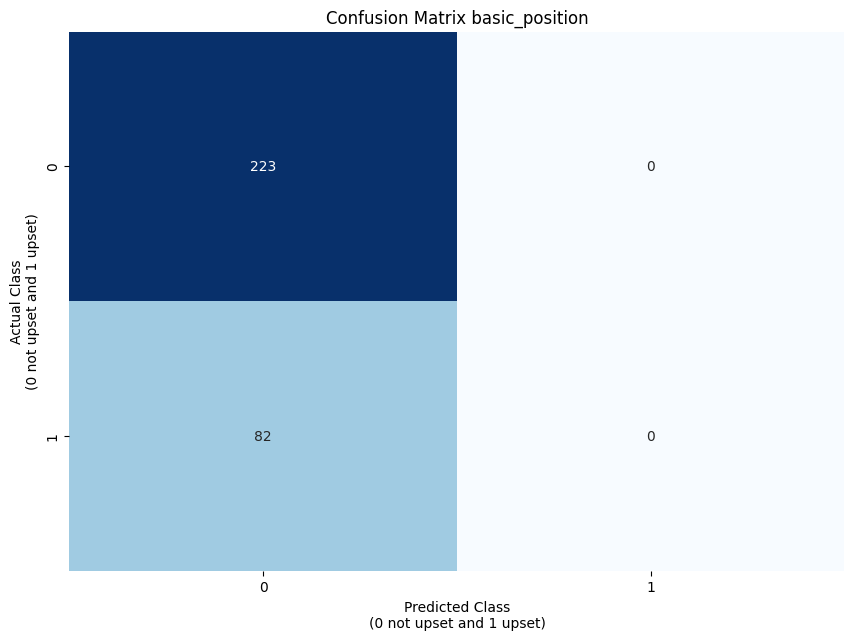

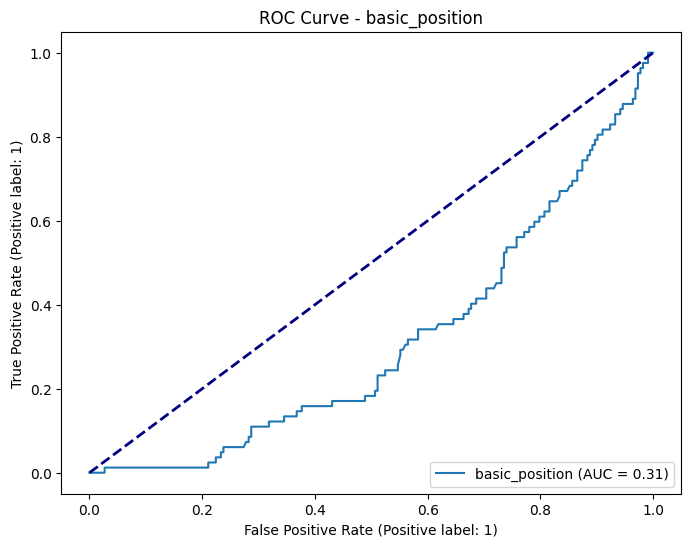

In [16]:
# Basic Position Ratings
ratings_model = 'basic_position'
ratings_function = basic_position_ratings
num_folds = 5

# Call ratings function and run cross validation

results = run_rating_models_cross_validation (fa_cup_scores_df, ratings_function, ratings_model, num_folds)

# Display results
display(results['predictions_df'])
display(results['upset_accuracy_scores_df'])
display(results['ratings_df'])
print(f"Mean Upset Accuracy: {results['mean_upset_accuracy']:.4f}")
print(f"Standard Deviation of Upset Accuracy: {results['std_upset_accuracy']:.4f}")

# Load predictions and ratinbgs to Google Big Query
predictions_df = results['predictions_df']
ratings_df = results['ratings_df']
load_predictions_and_ratings_to_bigquery(client, predictions_df, ratings_df, ratings_model)

# Create dataframe to compare rank and use for final rank aggregation
rank_df = ratings_df[['team_no', 'fold_number', 'rank']]
rank_df = rank_df.rename(columns={'rank': ratings_model})
all_ranks_df = all_ranks_df.merge(rank_df, on=['team_no','fold_number'], how='outer')
display(all_ranks_df)


# Create confusion matrix from results
results_df, cm_fig, roc_fig = create_model_results_df(results['all_actual_upsets'],results['all_predicted_upsets'], results['accuracies'], results['all_upset_probabilities'], ratings_model)
results_df = results_df.reset_index()
results_df['metric_id'] = results_df.index + 1
results_df = results_df[['metric_id', 'metric', ratings_model]]

all_results_df = all_results_df.merge(results_df, on=['metric_id', 'metric'], how='outer')
display(all_results_df)



Fold 1/5
Train data size: 244
Test data size: 61
massey
<function massey_ratings at 0x7b6fd91936d0>
244
[(1, 3.4990125882411163), (2, 2.4588366712053333), (3, 2.677367775707795), (4, 2.15156829872125), (5, 1.7265022713859721), (6, 1.1069645296359711), (7, -0.2662400385145385), (8, 0.11030214662705096), (9, 2.266628403680719), (10, 1.079634457972429), (11, -0.074766976057999), (12, 0.6277273550146055), (13, 0.6791882641531956), (14, 1.0232168291185009), (15, 1.1164946134701887), (16, -0.06326881003093773), (17, 0.14917162874839027), (18, 0.2834901979948522), (19, -0.5371929436889114), (20, 1.5169270481871842), (21, -0.538532714442148), (22, -0.07305887684691308), (23, -1.3598498650522541), (24, 0.977996245845167), (25, 1.6800387528565002), (26, -0.6424200088446094), (27, 0.5089155787060762), (28, 1.5665962782142555), (29, -1.8013173690167494), (30, 0.7770557655955439), (31, -0.28915094732490115), (32, 0.7565752153192322), (33, 0.3530414146021377), (34, -0.16181908721448962), (35, -1.338

,ratings_model,fold_number,match_id,home_team_no,home_team_league_level,away_team_no,away_team_league_level,home_team_rating,away_team_rating,predicted_winner,actual_winner,actual_upset,predicted_upset,upset_probability
1,massey,1,1428623,27,2,1,1,0.508916,3.499013,1,1,0,0,0.952125
2,massey,1,957292,2,1,22,2,2.458837,-0.073059,2,2,0,0,0.926348
3,massey,1,846113,2,1,42,2,2.458837,-0.198153,2,2,0,0,0.934441
4,massey,1,192160,2,1,41,2,2.458837,0.240833,2,2,0,0,0.901855
5,massey,1,883278,3,1,33,2,2.677368,0.353041,3,3,0,0,0.910872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,massey,5,1349449,61,5,46,3,-1.212211,1.126968,46,46,0,0,0.912070
302,massey,5,472572,47,3,64,6,0.155757,-0.961037,47,47,0,0,0.753394
303,massey,5,846034,47,3,63,5,0.155757,-1.997299,47,47,0,0,0.895954
304,massey,5,475990,58,4,54,3,-0.755272,-0.544731,54,58,1,0,0.552442


,accuracy
1,0.721311
2,0.655738
3,0.704918
4,0.721311
5,0.737705


,ratings_model,fold_number,team_no,rating,rank
320,massey,0,1,3.561441,1
0,massey,1,1,3.499013,1
4,massey,2,1,3.081205,1
2,massey,3,1,3.547028,1
1,massey,4,1,3.905430,1
...,...,...,...,...,...
317,massey,1,64,-1.391696,59
316,massey,2,64,-1.147045,53
318,massey,3,64,-1.748463,59
315,massey,4,64,-1.374850,57


Mean Upset Accuracy: 0.7082
Standard Deviation of Upset Accuracy: 0.0282
Big Query target predictions table analysis_layer.ratings_predictions rows deleted: 305
305 rows appended to predictions table analysis_layer.ratings_predictions successfully.
Big Query target ratings table analysis_layer.ratings rows deleted: 384
384 rows appended to ratings table analysis_layer.ratings successfully.


,team_no,fold_number,basic_position,massey
0,1,0,1,1
1,1,1,1,1
2,1,2,1,1
3,1,3,1,1
4,1,4,1,1
...,...,...,...,...
379,64,1,64,59
380,64,2,64,53
381,64,3,64,59
382,64,4,64,57


,metric_id,metric,basic_position,massey
0,1,Cross-validation Accuracy,0.731,0.708
1,2,Cross-validation Standard Deviation,0.008,0.028
2,3,Overall Accuracy,0.731,0.708
3,4,Confusion Matrix - True Negative (Class 0),223.000,192.000
4,5,Confusion Matrix - False Positive (Class 1),0.000,31.000
5,6,Confusion Matrix - False Negative (Class 0),82.000,58.000
6,7,Confusion Matrix - True Positive (Class 1),0.000,24.000
7,8,Precision (Class 0),0.731,0.768
8,9,Recall (Class 0),1.000,0.861
9,10,F1-score (Class 0),0.845,0.812


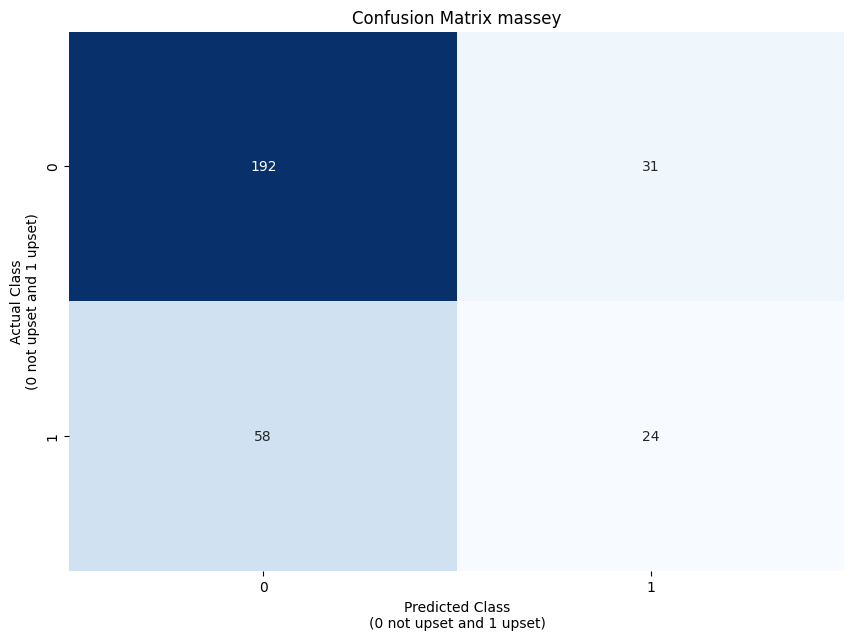

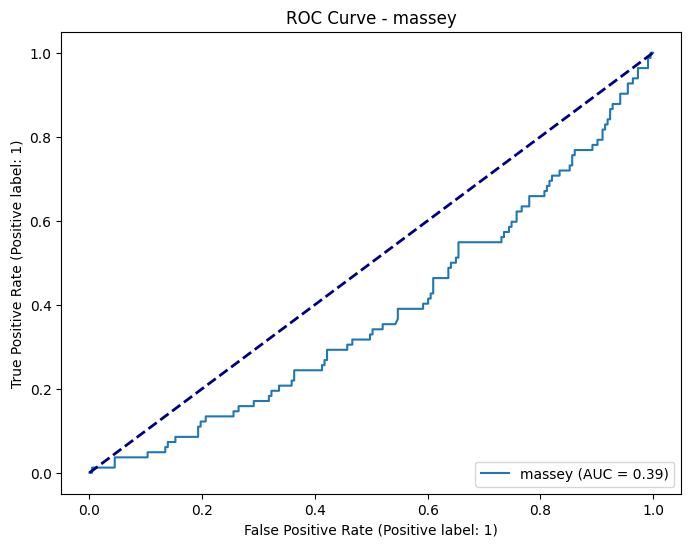

In [17]:
# Massey Ratings
ratings_model = 'massey'
ratings_function = massey_ratings
num_folds = 5

# Call ratings function and run cross validation
results = run_rating_models_cross_validation (fa_cup_scores_df, ratings_function, ratings_model, num_folds)

# Display results
display(results['predictions_df'])
display(results['upset_accuracy_scores_df'])
display(results['ratings_df'])
print(f"Mean Upset Accuracy: {results['mean_upset_accuracy']:.4f}")
print(f"Standard Deviation of Upset Accuracy: {results['std_upset_accuracy']:.4f}")

# Load predictions and ratinbgs to Google Big Query
predictions_df = results['predictions_df']
ratings_df = results['ratings_df']
load_predictions_and_ratings_to_bigquery(client, predictions_df, ratings_df, ratings_model)

# Create dataframe to compare rank and use for final rank aggregation
rank_df = ratings_df[['team_no', 'fold_number', 'rank']]
rank_df = rank_df.rename(columns={'rank': ratings_model})
all_ranks_df = all_ranks_df.merge(rank_df, on=['team_no','fold_number'], how='outer')
display(all_ranks_df)

# Create confusion matrix from results
results_df, cm_fig, roc_fig = create_model_results_df(results['all_actual_upsets'],results['all_predicted_upsets'], results['accuracies'], results['all_upset_probabilities'], ratings_model)
results_df = results_df.reset_index()
results_df['metric_id'] = results_df.index + 1
results_df = results_df[['metric_id', 'metric', ratings_model]]

all_results_df = all_results_df.merge(results_df, on=['metric_id', 'metric'], how='outer')
display(all_results_df)

Fold 1/5
Train data size: 244
Test data size: 61
colley
<function colley_ratings at 0x7b6fd9193a30>
244
[(1, 0.8488261339107486), (2, 0.754992092790853), (3, 0.8674964522221481), (4, 0.8363239229795076), (5, 0.8193966110628588), (6, 0.6715233176425662), (7, 0.4901439401199127), (8, 0.633861223917459), (9, 0.8357381577020009), (10, 0.7349781717233055), (11, 0.5882252840886426), (12, 0.6863609048423025), (13, 0.692051819402287), (14, 0.6607597787966), (15, 0.7485644686079548), (16, 0.491944898774501), (17, 0.5951291815069532), (18, 0.5278688491610909), (19, 0.3601528670433413), (20, 0.7128349944408052), (21, 0.3125831591638793), (22, 0.5348394865659838), (23, 0.3718194501817619), (24, 0.5212653739883213), (25, 0.6940263161212159), (26, 0.26567635997867906), (27, 0.5815462559246555), (28, 0.9098545745640935), (29, 0.18149149527129124), (30, 0.5613999649855976), (31, 0.38178775388108277), (32, 0.5451861082421192), (33, 0.4841614983301653), (34, 0.4593199763758439), (35, 0.3203856978655355)

,ratings_model,fold_number,match_id,home_team_no,home_team_league_level,away_team_no,away_team_league_level,home_team_rating,away_team_rating,predicted_winner,actual_winner,actual_upset,predicted_upset,upset_probability
1,colley,1,1428623,27,2,1,1,0.581546,0.848826,1,1,0,0,0.566425
2,colley,1,957292,2,1,22,2,0.754992,0.534839,2,2,0,0,0.554817
3,colley,1,846113,2,1,42,2,0.754992,0.424470,2,2,0,0,0.581886
4,colley,1,192160,2,1,41,2,0.754992,0.613408,2,2,0,0,0.535337
5,colley,1,883278,3,1,33,2,0.867496,0.484161,3,3,0,0,0.594677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,colley,5,1349449,61,5,46,3,0.245460,0.689262,46,46,0,0,0.609165
302,colley,5,472572,47,3,64,6,0.419467,0.245475,47,47,0,0,0.543389
303,colley,5,846034,47,3,63,5,0.419467,0.262351,47,47,0,0,0.539199
304,colley,5,475990,58,4,54,3,0.489366,0.403970,58,58,1,1,0.521336


,accuracy
1,0.688525
2,0.639344
3,0.688525
4,0.704918
5,0.786885


,ratings_model,fold_number,team_no,rating,rank
320,colley,0,1,0.880148,1
0,colley,1,1,0.848826,3
4,colley,2,1,0.919811,1
2,colley,3,1,0.857644,2
1,colley,4,1,0.920765,1
...,...,...,...,...,...
317,colley,1,64,0.140126,64
316,colley,2,64,0.189935,63
318,colley,3,64,0.116371,64
315,colley,4,64,0.165669,63


Mean Upset Accuracy: 0.7016
Standard Deviation of Upset Accuracy: 0.0480
Big Query target predictions table analysis_layer.ratings_predictions rows deleted: 305
305 rows appended to predictions table analysis_layer.ratings_predictions successfully.
Big Query target ratings table analysis_layer.ratings rows deleted: 384
384 rows appended to ratings table analysis_layer.ratings successfully.


,team_no,fold_number,basic_position,massey,colley
0,1,0,1,1,1
1,1,1,1,1,3
2,1,2,1,1,1
3,1,3,1,1,2
4,1,4,1,1,1
...,...,...,...,...,...
379,64,1,64,59,64
380,64,2,64,53,63
381,64,3,64,59,64
382,64,4,64,57,63


,metric_id,metric,basic_position,massey,colley
0,1,Cross-validation Accuracy,0.731,0.708,0.702
1,2,Cross-validation Standard Deviation,0.008,0.028,0.048
2,3,Overall Accuracy,0.731,0.708,0.702
3,4,Confusion Matrix - True Negative (Class 0),223.000,192.000,186.000
4,5,Confusion Matrix - False Positive (Class 1),0.000,31.000,37.000
5,6,Confusion Matrix - False Negative (Class 0),82.000,58.000,54.000
6,7,Confusion Matrix - True Positive (Class 1),0.000,24.000,28.000
7,8,Precision (Class 0),0.731,0.768,0.775
8,9,Recall (Class 0),1.000,0.861,0.834
9,10,F1-score (Class 0),0.845,0.812,0.803


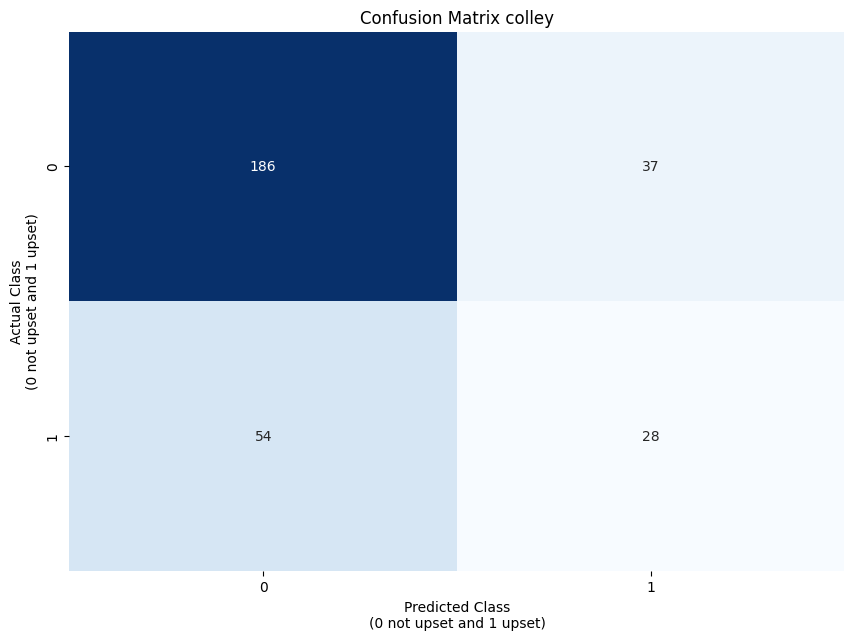

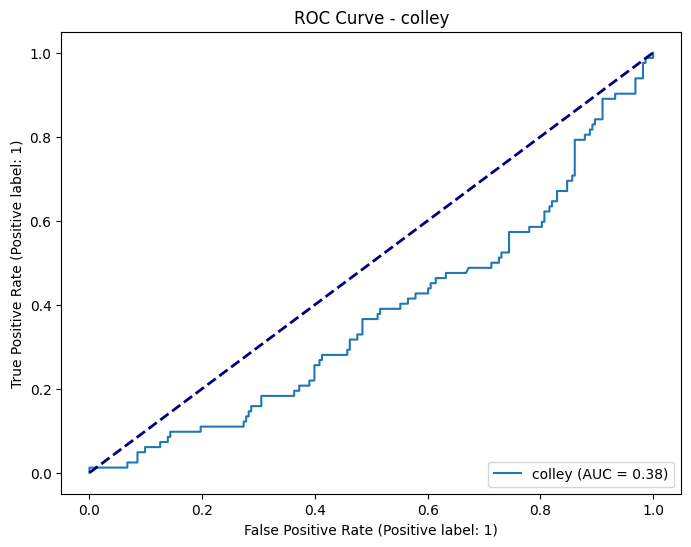

In [18]:
# Colley Ratings
ratings_model = 'colley'
ratings_function = colley_ratings
num_folds = 5

# Call ratings function and run cross validation
results = run_rating_models_cross_validation (fa_cup_scores_df, ratings_function, ratings_model, num_folds)

# Display results
display(results['predictions_df'])
display(results['upset_accuracy_scores_df'])
display(results['ratings_df'])
print(f"Mean Upset Accuracy: {results['mean_upset_accuracy']:.4f}")
print(f"Standard Deviation of Upset Accuracy: {results['std_upset_accuracy']:.4f}")

# Load predictions and ratinbgs to Google Big Query
predictions_df = results['predictions_df']
ratings_df = results['ratings_df']
load_predictions_and_ratings_to_bigquery(client, predictions_df, ratings_df, ratings_model)

# Create dataframe to compare rank and use for final rank aggregation
rank_df = ratings_df[['team_no', 'fold_number', 'rank']]
rank_df = rank_df.rename(columns={'rank': ratings_model})
all_ranks_df = all_ranks_df.merge(rank_df, on=['team_no','fold_number'], how='outer')
display(all_ranks_df)

# Create confusion matrix from results
results_df, cm_fig, roc_fig = create_model_results_df(results['all_actual_upsets'],results['all_predicted_upsets'], results['accuracies'], results['all_upset_probabilities'], ratings_model)
results_df = results_df.reset_index()
results_df['metric_id'] = results_df.index + 1
results_df = results_df[['metric_id', 'metric', ratings_model]]

all_results_df = all_results_df.merge(results_df, on=['metric_id', 'metric'], how='outer')
display(all_results_df)



Fold 1/5
Train data size: 244
Test data size: 61
keener
<function keener_ratings at 0x7b6fd9193ac0>
[(1, 0.12965092506422815), (2, 0.13327932801691972), (3, 0.13573038917859948), (4, 0.1359991159938689), (5, 0.13884920185549762), (6, 0.1320831849157278), (7, 0.12555570734979213), (8, 0.12971935299515286), (9, 0.13107038925186143), (10, 0.13107105886499923), (11, 0.12862599169723551), (12, 0.1300606769098699), (13, 0.1268119219964595), (14, 0.12873578276368286), (15, 0.12920859501354204), (16, 0.12584539088181998), (17, 0.12760806222838073), (18, 0.1313232147611049), (19, 0.12496942962962121), (20, 0.1299783337714216), (21, 0.12257846263190782), (22, 0.12575681439676017), (23, 0.11945780541867047), (24, 0.12664227292818506), (25, 0.13187552809482003), (26, 0.12061028738168411), (27, 0.12474976573484504), (28, 0.13174082749580124), (29, 0.1186453335469637), (30, 0.12582014132490882), (31, 0.11886199119083449), (32, 0.12404865929468693), (33, 0.12439089698441548), (34, 0.12486045978985645

,ratings_model,fold_number,match_id,home_team_no,home_team_league_level,away_team_no,away_team_league_level,home_team_rating,away_team_rating,predicted_winner,actual_winner,actual_upset,predicted_upset,upset_probability
1,keener,1,1428623,27,2,1,1,0.124750,0.129651,1,1,0,0,0.501225
2,keener,1,957292,2,1,22,2,0.133279,0.125757,2,2,0,0,0.501881
3,keener,1,846113,2,1,42,2,0.133279,0.124141,2,2,0,0,0.502284
4,keener,1,192160,2,1,41,2,0.133279,0.125835,2,2,0,0,0.501861
5,keener,1,883278,3,1,33,2,0.135730,0.124391,3,3,0,0,0.502835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,keener,5,1349449,61,5,46,3,0.117885,0.129202,46,46,0,0,0.502829
302,keener,5,472572,47,3,64,6,0.123818,0.119683,47,47,0,0,0.501034
303,keener,5,846034,47,3,63,5,0.123818,0.120099,47,47,0,0,0.500930
304,keener,5,475990,58,4,54,3,0.125524,0.121075,58,58,1,1,0.501112


,accuracy
1,0.737705
2,0.704918
3,0.721311
4,0.688525
5,0.770492


,ratings_model,fold_number,team_no,rating,rank
331,keener,0,1,0.130056,12
0,keener,1,1,0.129651,14
4,keener,2,1,0.129359,13
2,keener,3,1,0.130527,10
1,keener,4,1,0.129784,12
...,...,...,...,...,...
317,keener,1,64,0.119528,54
316,keener,2,64,0.119274,56
318,keener,3,64,0.120040,54
315,keener,4,64,0.118143,60


Mean Upset Accuracy: 0.7246
Standard Deviation of Upset Accuracy: 0.0282
Big Query target predictions table analysis_layer.ratings_predictions rows deleted: 305
305 rows appended to predictions table analysis_layer.ratings_predictions successfully.
Big Query target ratings table analysis_layer.ratings rows deleted: 384
384 rows appended to ratings table analysis_layer.ratings successfully.


,team_no,fold_number,basic_position,massey,colley,keener
0,1,0,1,1,1,12
1,1,1,1,1,3,14
2,1,2,1,1,1,13
3,1,3,1,1,2,10
4,1,4,1,1,1,12
...,...,...,...,...,...,...
379,64,1,64,59,64,54
380,64,2,64,53,63,56
381,64,3,64,59,64,54
382,64,4,64,57,63,60


,metric_id,metric,basic_position,massey,colley,keener
0,1,Cross-validation Accuracy,0.731,0.708,0.702,0.725
1,2,Cross-validation Standard Deviation,0.008,0.028,0.048,0.028
2,3,Overall Accuracy,0.731,0.708,0.702,0.725
3,4,Confusion Matrix - True Negative (Class 0),223.000,192.000,186.000,199.000
4,5,Confusion Matrix - False Positive (Class 1),0.000,31.000,37.000,24.000
5,6,Confusion Matrix - False Negative (Class 0),82.000,58.000,54.000,60.000
6,7,Confusion Matrix - True Positive (Class 1),0.000,24.000,28.000,22.000
7,8,Precision (Class 0),0.731,0.768,0.775,0.768
8,9,Recall (Class 0),1.000,0.861,0.834,0.892
9,10,F1-score (Class 0),0.845,0.812,0.803,0.826


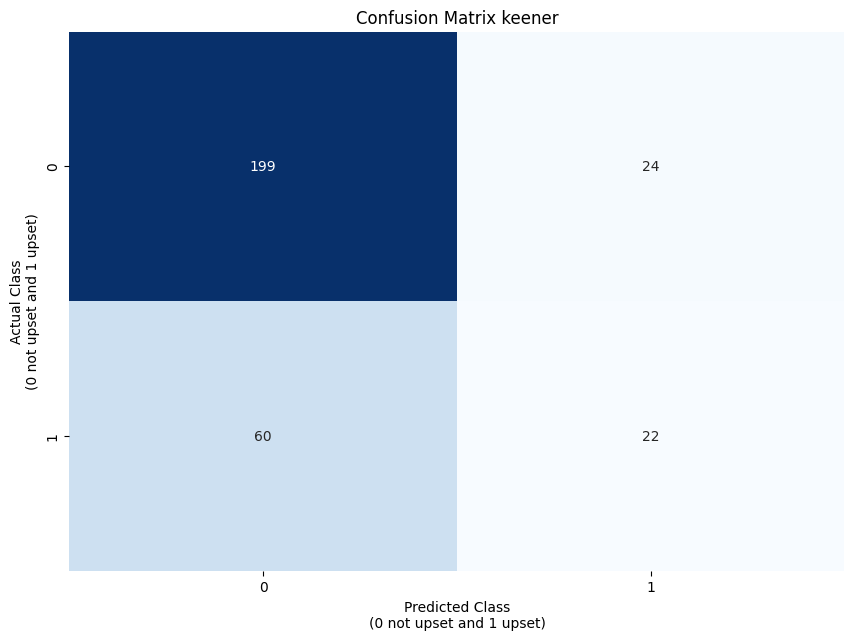

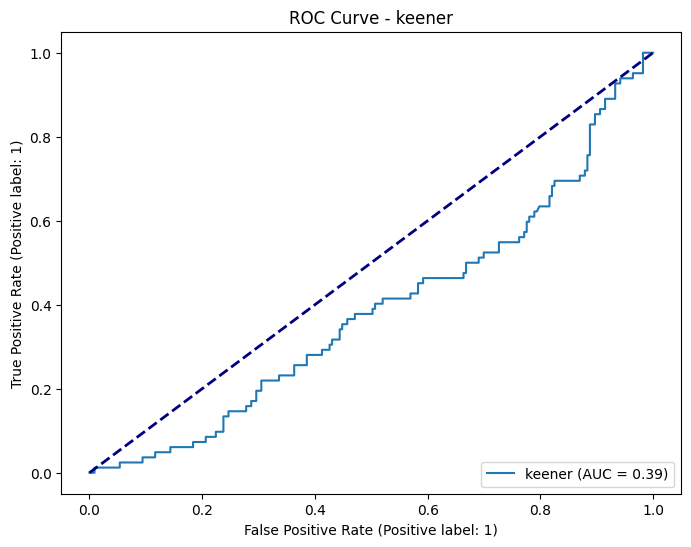

In [19]:
# Keener Ratings
ratings_model = 'keener'
ratings_function = keener_ratings
num_folds = 5

# Call ratings function and run cross validation
results = run_rating_models_cross_validation (fa_cup_scores_df, ratings_function, ratings_model, num_folds)

# Display results
display(results['predictions_df'])
display(results['upset_accuracy_scores_df'])
display(results['ratings_df'])
print(f"Mean Upset Accuracy: {results['mean_upset_accuracy']:.4f}")
print(f"Standard Deviation of Upset Accuracy: {results['std_upset_accuracy']:.4f}")

# Load predictions and ratinbgs to Google Big Query
predictions_df = results['predictions_df']
ratings_df = results['ratings_df']
load_predictions_and_ratings_to_bigquery(client, predictions_df, ratings_df, ratings_model)

# Create dataframe to compare rank and use for final rank aggregation
rank_df = ratings_df[['team_no', 'fold_number', 'rank']]
rank_df = rank_df.rename(columns={'rank': ratings_model})
all_ranks_df = all_ranks_df.merge(rank_df, on=['team_no','fold_number'], how='outer')
display(all_ranks_df)

# Create confusion matrix from results
results_df, cm_fig, roc_fig = create_model_results_df(results['all_actual_upsets'],results['all_predicted_upsets'], results['accuracies'], results['all_upset_probabilities'], ratings_model)
results_df = results_df.reset_index()
results_df['metric_id'] = results_df.index + 1
results_df = results_df[['metric_id', 'metric', ratings_model]]

all_results_df = all_results_df.merge(results_df, on=['metric_id', 'metric'], how='outer')
display(all_results_df)

Fold 1/5
Train data size: 244
Test data size: 61
trueskill
<function trueskill_ratings at 0x7b6fd9193b50>
[(60, 20.458079224667), (63, 20.868535898317596), (56, 23.616566388350186), (6, 28.87192961278041), (13, 30.86847211207806), (41, 28.193683234643984), (39, 18.461667670958658), (48, 17.001994202268797), (62, 17.914506963799166), (38, 29.12114169877174), (33, 24.158770261249884), (9, 35.97673629726464), (34, 21.94039005283649), (59, 19.877338948839153), (30, 24.748314135330904), (55, 30.060538113484284), (10, 30.58107423133897), (36, 27.80309964639096), (50, 25.34277271389795), (18, 24.588603034065418), (5, 37.619567625922286), (35, 19.808868502957463), (43, 18.642229592476188), (2, 33.2714968993821), (54, 18.157116555247207), (4, 38.897014140230496), (64, 15.216278905566693), (19, 20.879494661675903), (57, 21.225612157911886), (31, 21.173539286554416), (47, 24.796900514647696), (20, 28.08387207569568), (28, 37.372972291914095), (45, 25.913230872837417), (49, 27.708114596660447), (3

,ratings_model,fold_number,match_id,home_team_no,home_team_league_level,away_team_no,away_team_league_level,home_team_rating,away_team_rating,predicted_winner,actual_winner,actual_upset,predicted_upset,upset_probability
1,trueskill,1,1428623,27,2,1,1,28.269022,38.954896,1,1,0,0,0.999977
2,trueskill,1,957292,2,1,22,2,33.271497,26.466876,2,2,0,0,0.998893
3,trueskill,1,846113,2,1,42,2,33.271497,23.689128,2,2,0,0,0.999931
4,trueskill,1,192160,2,1,41,2,33.271497,28.193683,2,2,0,0,0.993805
5,trueskill,1,883278,3,1,33,2,36.442841,24.158770,3,3,0,0,0.999995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,trueskill,5,1349449,61,5,46,3,15.947187,28.750746,46,46,0,0,0.999997
302,trueskill,5,472572,47,3,64,6,22.092144,17.804149,47,47,0,0,0.986454
303,trueskill,5,846034,47,3,63,5,22.092144,19.249842,47,47,0,0,0.944919
304,trueskill,5,475990,58,4,54,3,23.916415,22.755450,58,58,1,1,0.761508


,accuracy
1,0.672131
2,0.639344
3,0.721311
4,0.721311
5,0.786885


,ratings_model,fold_number,team_no,rating,rank
320,trueskill,0,1,38.184180,1
2,trueskill,1,1,38.954896,1
1,trueskill,2,1,38.696935,1
3,trueskill,3,1,36.791587,2
4,trueskill,4,1,38.989296,1
...,...,...,...,...,...
315,trueskill,1,64,15.216279,62
318,trueskill,2,64,16.770261,59
317,trueskill,3,64,15.793976,62
319,trueskill,4,64,16.134150,61


Mean Upset Accuracy: 0.7082
Standard Deviation of Upset Accuracy: 0.0502
Big Query target predictions table analysis_layer.ratings_predictions rows deleted: 305
305 rows appended to predictions table analysis_layer.ratings_predictions successfully.
Big Query target ratings table analysis_layer.ratings rows deleted: 384
384 rows appended to ratings table analysis_layer.ratings successfully.


,team_no,fold_number,basic_position,massey,colley,keener,trueskill
0,1,0,1,1,1,12,1
1,1,1,1,1,3,14,1
2,1,2,1,1,1,13,1
3,1,3,1,1,2,10,2
4,1,4,1,1,1,12,1
...,...,...,...,...,...,...,...
379,64,1,64,59,64,54,62
380,64,2,64,53,63,56,59
381,64,3,64,59,64,54,62
382,64,4,64,57,63,60,61


,metric_id,metric,basic_position,massey,colley,keener,trueskill
0,1,Cross-validation Accuracy,0.731,0.708,0.702,0.725,0.708
1,2,Cross-validation Standard Deviation,0.008,0.028,0.048,0.028,0.050
2,3,Overall Accuracy,0.731,0.708,0.702,0.725,0.708
3,4,Confusion Matrix - True Negative (Class 0),223.000,192.000,186.000,199.000,181.000
4,5,Confusion Matrix - False Positive (Class 1),0.000,31.000,37.000,24.000,42.000
5,6,Confusion Matrix - False Negative (Class 0),82.000,58.000,54.000,60.000,47.000
6,7,Confusion Matrix - True Positive (Class 1),0.000,24.000,28.000,22.000,35.000
7,8,Precision (Class 0),0.731,0.768,0.775,0.768,0.794
8,9,Recall (Class 0),1.000,0.861,0.834,0.892,0.812
9,10,F1-score (Class 0),0.845,0.812,0.803,0.826,0.803


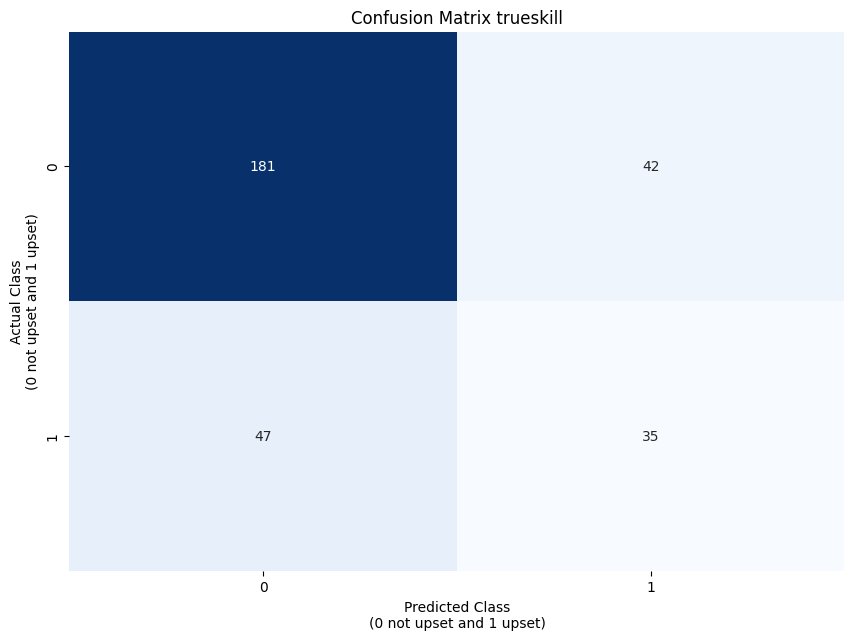

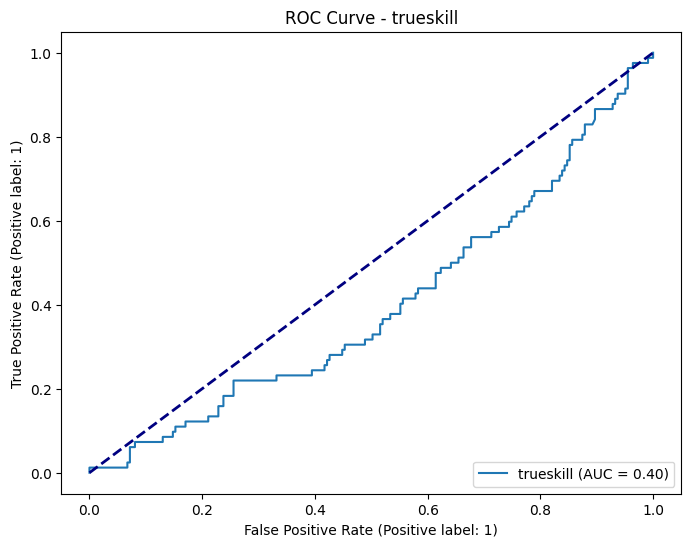

In [20]:
# Trueskill Ratings
ratings_model = 'trueskill'
ratings_function = trueskill_ratings
num_folds = 5

# Call ratings function and run cross validation
results = run_rating_models_cross_validation (fa_cup_scores_df, ratings_function, ratings_model, num_folds)

# Display results
display(results['predictions_df'])
display(results['upset_accuracy_scores_df'])
display(results['ratings_df'])
print(f"Mean Upset Accuracy: {results['mean_upset_accuracy']:.4f}")
print(f"Standard Deviation of Upset Accuracy: {results['std_upset_accuracy']:.4f}")

# Load predictions and ratinbgs to Google Big Query
predictions_df = results['predictions_df']
ratings_df = results['ratings_df']
load_predictions_and_ratings_to_bigquery(client, predictions_df, ratings_df, ratings_model)

# Create dataframe to compare rank and use for final rank aggregation
rank_df = ratings_df[['team_no', 'fold_number', 'rank']]
rank_df = rank_df.rename(columns={'rank': ratings_model})
all_ranks_df = all_ranks_df.merge(rank_df, on=['team_no','fold_number'], how='outer')
display(all_ranks_df)

# Create confusion matrix from results
results_df, cm_fig, roc_fig = create_model_results_df(results['all_actual_upsets'],results['all_predicted_upsets'], results['accuracies'], results['all_upset_probabilities'], ratings_model)
results_df = results_df.reset_index()
results_df['metric_id'] = results_df.index + 1
results_df = results_df[['metric_id', 'metric', ratings_model]]

all_results_df = all_results_df.merge(results_df, on=['metric_id', 'metric'], how='outer')
display(all_results_df)

In [21]:
# Load all ranks df to Big Query
load_dataset_name = 'analysis_layer'
load_table_name = 'ratings_model_ranks'
full_table_name = f"{load_dataset_name}.{load_table_name}"
pandas_gbq.to_gbq(all_ranks_df, full_table_name, project_id='birkbeck-msc-project-422917', if_exists='replace')

# Load confusion matrix df to Big Query
load_dataset_name = 'analysis_layer'
load_table_name = 'ratings_model_confusion_matrix_results'
full_table_name = f"{load_dataset_name}.{load_table_name}"
pandas_gbq.to_gbq(all_results_df, full_table_name, project_id='birkbeck-msc-project-422917', if_exists='replace')



100%|██████████| 1/1 [00:00<00:00, 7570.95it/s]


In [22]:
# Rank Aggregation functions called after ratings function have run and results inserted into Big Query

def borda_count_aggregation (fold_counter):

    from google.cloud import bigquery

    # Authenticate using the loaded key
    credentials = service_account.Credentials.from_service_account_info(key)
    # Set up the BigQuery client with the credentials to project
    client = bigquery.Client(credentials=credentials, project='birkbeck-msc-project-422917')

    fold_number = fold_counter
    all_ranks = """
              select * from analysis_layer.ratings_model_ranks
              """

    all_ranks_df = client.query(all_ranks).to_dataframe()
    all_ranks_df_fold = all_ranks_df[all_ranks_df['fold_number'] == fold_number].sort_values('team_no', ascending=True)
    all_ranks_df_fold['rank_total'] = all_ranks_df_fold[['basic_position','massey','colley','keener','trueskill']].sum(axis=1)
    all_ranks_df_fold['overall_rank'] = all_ranks_df_fold['rank_total'].rank(method='first', ascending=True).astype(int)
    all_ranks_df_fold['rating'] = 1 / all_ranks_df_fold['overall_rank']


    # Create a list of tuples in the format (team_no, rating) for function
    ratings = list(zip(all_ranks_df_fold['team_no'], all_ranks_df_fold['rating']))

    return ratings

def average_rank_aggregation (fold_counter):

    from google.cloud import bigquery

    # Authenticate using the loaded key
    credentials = service_account.Credentials.from_service_account_info(key)
    # Set up the BigQuery client with the credentials to project
    client = bigquery.Client(credentials=credentials, project='birkbeck-msc-project-422917')

    fold_number = fold_counter
    all_ranks = """
              select * from analysis_layer.ratings_model_ranks
              """

    all_ranks_df = client.query(all_ranks).to_dataframe()
    all_ranks_df_fold = all_ranks_df[all_ranks_df['fold_number'] == fold_number].sort_values('team_no', ascending=True)
    all_ranks_df_fold['rank_average'] = all_ranks_df_fold[['basic_position','massey','colley','keener','trueskill']].mean(axis=1)
    all_ranks_df_fold['overall_rank'] = all_ranks_df_fold['rank_average'].rank(method='first', ascending=True).astype(int)
    all_ranks_df_fold['rating'] = 1 / all_ranks_df_fold['overall_rank']
    display(all_ranks_df_fold)


    # Create a list of tuples in the format (team_no, rating) for function
    ratings = list(zip(all_ranks_df_fold['team_no'], all_ranks_df_fold['rating']))

    return ratings


Fold 1/5
Train data size: 244
Test data size: 61
borda_count
<function borda_count_aggregation at 0x7b6fd8d1f880>
[(1, 0.3333333333333333), (2, 0.2), (3, 1.0), (4, 0.5), (5, 0.25), (6, 0.125), (7, 0.03571428571428571), (8, 0.0625), (9, 0.16666666666666666), (10, 0.1111111111111111), (11, 0.058823529411764705), (12, 0.06666666666666667), (13, 0.07142857142857142), (14, 0.07692307692307693), (15, 0.1), (16, 0.034482758620689655), (17, 0.05555555555555555), (18, 0.05), (19, 0.027777777777777776), (20, 0.08333333333333333), (21, 0.025), (22, 0.037037037037037035), (23, 0.022727272727272728), (24, 0.047619047619047616), (25, 0.09090909090909091), (26, 0.021739130434782608), (27, 0.045454545454545456), (28, 0.14285714285714285), (29, 0.017241379310344827), (30, 0.041666666666666664), (31, 0.023809523809523808), (32, 0.03333333333333333), (33, 0.03125), (34, 0.02857142857142857), (35, 0.02127659574468085), (36, 0.05263157894736842), (37, 0.022222222222222223), (38, 0.038461538461538464), (39,

,ratings_model,fold_number,match_id,home_team_no,home_team_league_level,away_team_no,away_team_league_level,home_team_rating,away_team_rating,predicted_winner,actual_winner,actual_upset,predicted_upset,upset_probability
1,borda_count,1,1428623,27,2,1,1,0.045455,0.333333,1,1,0,0,0.571477
2,borda_count,1,957292,2,1,22,2,0.200000,0.037037,2,2,0,0,0.540651
3,borda_count,1,846113,2,1,42,2,0.200000,0.025641,2,2,0,0,0.543480
4,borda_count,1,192160,2,1,41,2,0.200000,0.043478,2,2,0,0,0.539051
5,borda_count,1,883278,3,1,33,2,1.000000,0.031250,3,3,0,0,0.724870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,borda_count,5,1349449,61,5,46,3,0.015873,0.052632,46,46,0,0,0.509189
302,borda_count,5,472572,47,3,64,6,0.029412,0.016667,47,47,0,0,0.503186
303,borda_count,5,846034,47,3,63,5,0.029412,0.016393,47,47,0,0,0.503255
304,borda_count,5,475990,58,4,54,3,0.025641,0.020833,58,58,1,1,0.501202


,accuracy
1,0.754098
2,0.770492
3,0.786885
4,0.672131
5,0.803279


,ratings_model,fold_number,team_no,rating,rank
320,borda_count,0,1,0.666667,1
0,borda_count,1,1,0.333333,3
4,borda_count,2,1,1.000000,1
2,borda_count,3,1,0.500000,2
1,borda_count,4,1,0.500000,2
...,...,...,...,...,...
317,borda_count,1,64,0.015625,64
316,borda_count,2,64,0.016129,62
318,borda_count,3,64,0.015625,64
315,borda_count,4,64,0.015873,63


Mean Upset Accuracy: 0.7574
Standard Deviation of Upset Accuracy: 0.0457
Big Query target predictions table analysis_layer.ratings_predictions rows deleted: 305
305 rows appended to predictions table analysis_layer.ratings_predictions successfully.
Big Query target ratings table analysis_layer.ratings rows deleted: 384
384 rows appended to ratings table analysis_layer.ratings successfully.


,team_no,fold_number,basic_position,massey,colley,keener,trueskill,borda_count
0,1,0,1,1,1,12,1,1
1,1,1,1,1,3,14,1,3
2,1,2,1,1,1,13,1,1
3,1,3,1,1,2,10,2,2
4,1,4,1,1,1,12,1,2
...,...,...,...,...,...,...,...,...
379,64,1,64,59,64,54,62,64
380,64,2,64,53,63,56,59,62
381,64,3,64,59,64,54,62,64
382,64,4,64,57,63,60,61,63


[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0]
borda_count


,metric_id,metric,basic_position,massey,colley,keener,trueskill,borda_count
0,1,Cross-validation Accuracy,0.731,0.708,0.702,0.725,0.708,0.757
1,2,Cross-validation Standard Deviation,0.008,0.028,0.048,0.028,0.050,0.046
2,3,Overall Accuracy,0.731,0.708,0.702,0.725,0.708,0.757
3,4,Confusion Matrix - True Negative (Class 0),223.000,192.000,186.000,199.000,181.000,207.000
4,5,Confusion Matrix - False Positive (Class 1),0.000,31.000,37.000,24.000,42.000,16.000
5,6,Confusion Matrix - False Negative (Class 0),82.000,58.000,54.000,60.000,47.000,58.000
6,7,Confusion Matrix - True Positive (Class 1),0.000,24.000,28.000,22.000,35.000,24.000
7,8,Precision (Class 0),0.731,0.768,0.775,0.768,0.794,0.781
8,9,Recall (Class 0),1.000,0.861,0.834,0.892,0.812,0.928
9,10,F1-score (Class 0),0.845,0.812,0.803,0.826,0.803,0.848


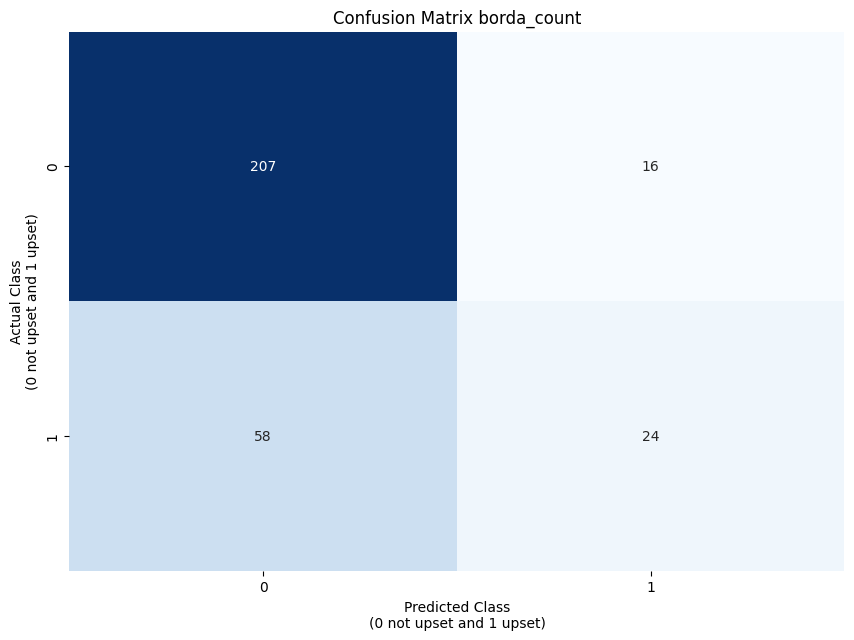

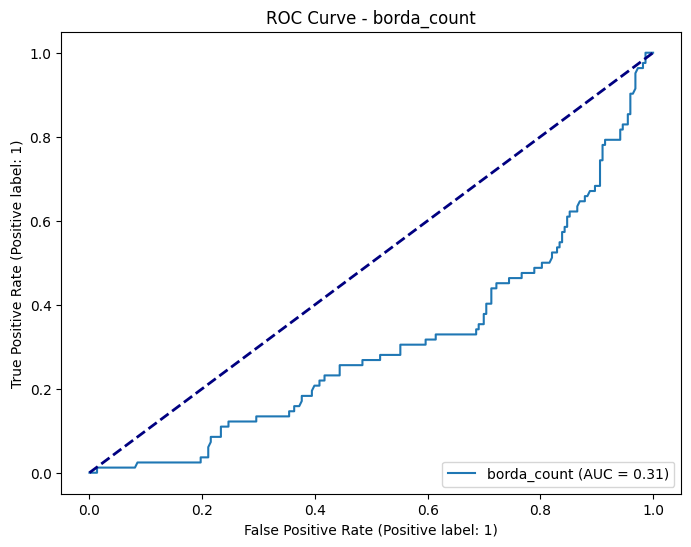

In [23]:
# Borda Count Aggregation
ratings_model = 'borda_count'
ratings_function = borda_count_aggregation
num_folds = 5

# Call ratings function and run cross validation
results = run_rating_models_cross_validation (fa_cup_scores_df, ratings_function, ratings_model, num_folds)

# Display results
display(results['predictions_df'])
display(results['upset_accuracy_scores_df'])
display(results['ratings_df'])
print(f"Mean Upset Accuracy: {results['mean_upset_accuracy']:.4f}")
print(f"Standard Deviation of Upset Accuracy: {results['std_upset_accuracy']:.4f}")

# Load predictions and ratinbgs to Google Big Query
predictions_df = results['predictions_df']
ratings_df = results['ratings_df']
load_predictions_and_ratings_to_bigquery(client, predictions_df, ratings_df, ratings_model)

# Create dataframe to compare rank and use for final rank aggregation
rank_df = ratings_df[['team_no', 'fold_number', 'rank']]
rank_df = rank_df.rename(columns={'rank': ratings_model})
all_ranks_df = all_ranks_df.merge(rank_df, on=['team_no','fold_number'], how='outer')
display(all_ranks_df)

print(results['all_actual_upsets'])
print(ratings_model)

# Create confusion matrix from results
results_df, cm_fig, roc_fig = create_model_results_df(results['all_actual_upsets'],results['all_predicted_upsets'], results['accuracies'], results['all_upset_probabilities'], ratings_model)
results_df = results_df.reset_index()
results_df['metric_id'] = results_df.index + 1
results_df = results_df[['metric_id', 'metric', ratings_model]]

all_results_df = all_results_df.merge(results_df, on=['metric_id', 'metric'], how='outer')
display(all_results_df)

Fold 1/5
Train data size: 244
Test data size: 61
average_rank
<function average_rank_aggregation at 0x7b6fd8d1f910>


,team_no,fold_number,basic_position,massey,colley,keener,trueskill,rank_average,overall_rank,rating
5,1,1,1,1,3,14,1,4.0,3,0.333333
8,2,1,2,3,7,4,8,4.8,5,0.200000
13,3,1,3,2,2,3,5,3.0,1,1.000000
20,4,1,4,5,4,2,2,3.4,2,0.500000
26,5,1,5,6,6,1,3,4.2,4,0.250000
...,...,...,...,...,...,...,...,...,...,...
357,60,1,60,63,50,44,48,53.0,55,0.018182
364,61,1,61,56,61,62,61,60.2,63,0.015873
368,62,1,62,49,56,64,58,57.8,62,0.016129
373,63,1,63,61,45,50,46,53.0,56,0.017857


[(1, 0.3333333333333333), (2, 0.2), (3, 1.0), (4, 0.5), (5, 0.25), (6, 0.125), (7, 0.03571428571428571), (8, 0.0625), (9, 0.16666666666666666), (10, 0.1111111111111111), (11, 0.058823529411764705), (12, 0.06666666666666667), (13, 0.07142857142857142), (14, 0.07692307692307693), (15, 0.1), (16, 0.034482758620689655), (17, 0.05555555555555555), (18, 0.05), (19, 0.027777777777777776), (20, 0.08333333333333333), (21, 0.025), (22, 0.037037037037037035), (23, 0.022727272727272728), (24, 0.047619047619047616), (25, 0.09090909090909091), (26, 0.021739130434782608), (27, 0.045454545454545456), (28, 0.14285714285714285), (29, 0.017241379310344827), (30, 0.041666666666666664), (31, 0.023809523809523808), (32, 0.03333333333333333), (33, 0.03125), (34, 0.02857142857142857), (35, 0.02127659574468085), (36, 0.05263157894736842), (37, 0.022222222222222223), (38, 0.038461538461538464), (39, 0.02), (40, 0.02631578947368421), (41, 0.043478260869565216), (42, 0.02564102564102564), (43, 0.0196078431372549)

,team_no,fold_number,basic_position,massey,colley,keener,trueskill,rank_average,overall_rank,rating
1,1,2,1,1,1,13,1,3.4,1,1.000000
11,2,2,2,2,11,5,9,5.8,6,0.166667
14,3,2,3,3,3,10,6,5.0,4,0.250000
21,4,2,4,4,4,4,5,4.2,2,0.500000
28,5,2,5,9,8,1,3,5.2,5,0.200000
...,...,...,...,...,...,...,...,...,...,...
359,60,2,60,64,59,57,57,59.4,63,0.015873
360,61,2,61,51,43,61,52,53.6,55,0.018182
369,62,2,62,46,56,44,60,53.6,56,0.017857
376,63,2,63,63,60,58,58,60.4,64,0.015625


[(1, 1.0), (2, 0.16666666666666666), (3, 0.25), (4, 0.5), (5, 0.2), (6, 0.06666666666666667), (7, 0.025), (8, 0.1), (9, 0.05), (10, 0.3333333333333333), (11, 0.045454545454545456), (12, 0.14285714285714285), (13, 0.041666666666666664), (14, 0.058823529411764705), (15, 0.1111111111111111), (16, 0.07692307692307693), (17, 0.08333333333333333), (18, 0.07142857142857142), (19, 0.03225806451612903), (20, 0.125), (21, 0.024390243902439025), (22, 0.02564102564102564), (23, 0.02040816326530612), (24, 0.05555555555555555), (25, 0.09090909090909091), (26, 0.023809523809523808), (27, 0.038461538461538464), (28, 0.0625), (29, 0.023255813953488372), (30, 0.043478260869565216), (31, 0.017241379310344827), (32, 0.034482758620689655), (33, 0.029411764705882353), (34, 0.02631578947368421), (35, 0.0196078431372549), (36, 0.047619047619047616), (37, 0.03125), (38, 0.05263157894736842), (39, 0.030303030303030304), (40, 0.019230769230769232), (41, 0.02702702702702703), (42, 0.022222222222222223), (43, 0.01

,team_no,fold_number,basic_position,massey,colley,keener,trueskill,rank_average,overall_rank,rating
4,1,3,1,1,2,10,2,3.2,2,0.500000
9,2,3,2,6,9,5,7,5.8,5,0.200000
17,3,3,3,2,5,7,5,4.4,3,0.333333
18,4,3,4,3,1,1,1,2.0,1,1.000000
27,5,3,5,7,6,3,3,4.8,4,0.250000
...,...,...,...,...,...,...,...,...,...,...
355,60,3,60,58,46,41,43,49.6,49,0.020408
361,61,3,61,45,51,55,58,54.0,57,0.017544
366,62,3,62,53,54,61,56,57.2,62,0.016129
372,63,3,63,57,40,49,45,50.8,50,0.020000


[(1, 0.5), (2, 0.2), (3, 0.3333333333333333), (4, 1.0), (5, 0.25), (6, 0.07142857142857142), (7, 0.020833333333333332), (8, 0.1111111111111111), (9, 0.04), (10, 0.16666666666666666), (11, 0.058823529411764705), (12, 0.09090909090909091), (13, 0.14285714285714285), (14, 0.05555555555555555), (15, 0.125), (16, 0.05263157894736842), (17, 0.1), (18, 0.05), (19, 0.034482758620689655), (20, 0.07692307692307693), (21, 0.022727272727272728), (22, 0.02631578947368421), (23, 0.02702702702702703), (24, 0.043478260869565216), (25, 0.08333333333333333), (26, 0.025), (27, 0.038461538461538464), (28, 0.0625), (29, 0.027777777777777776), (30, 0.047619047619047616), (31, 0.018518518518518517), (32, 0.03333333333333333), (33, 0.029411764705882353), (34, 0.037037037037037035), (35, 0.0196078431372549), (36, 0.06666666666666667), (37, 0.030303030303030304), (38, 0.041666666666666664), (39, 0.024390243902439025), (40, 0.02857142857142857), (41, 0.019230769230769232), (42, 0.01818181818181818), (43, 0.01785

,team_no,fold_number,basic_position,massey,colley,keener,trueskill,rank_average,overall_rank,rating
2,1,4,1,1,1,12,1,3.2,2,0.500000
6,2,4,2,4,2,1,2,2.2,1,1.000000
15,3,4,3,3,3,4,3,3.2,3,0.333333
22,4,4,4,2,4,2,4,3.2,4,0.250000
29,5,4,5,5,8,3,7,5.6,5,0.200000
...,...,...,...,...,...,...,...,...,...,...
354,60,4,60,64,45,48,37,50.8,52,0.019231
363,61,4,61,52,58,58,60,57.8,62,0.016129
367,62,4,62,53,55,59,53,56.4,61,0.016393
375,63,4,63,62,54,47,50,55.2,58,0.017241


[(1, 0.5), (2, 1.0), (3, 0.3333333333333333), (4, 0.25), (5, 0.2), (6, 0.16666666666666666), (7, 0.024390243902439025), (8, 0.1), (9, 0.05263157894736842), (10, 0.14285714285714285), (11, 0.045454545454545456), (12, 0.1111111111111111), (13, 0.07142857142857142), (14, 0.05555555555555555), (15, 0.125), (16, 0.058823529411764705), (17, 0.06666666666666667), (18, 0.08333333333333333), (19, 0.02702702702702703), (20, 0.0625), (21, 0.025), (22, 0.027777777777777776), (23, 0.018867924528301886), (24, 0.043478260869565216), (25, 0.09090909090909091), (26, 0.022727272727272728), (27, 0.05), (28, 0.07692307692307693), (29, 0.020833333333333332), (30, 0.038461538461538464), (31, 0.021739130434782608), (32, 0.04), (33, 0.03333333333333333), (34, 0.02857142857142857), (35, 0.017857142857142856), (36, 0.047619047619047616), (37, 0.023255813953488372), (38, 0.041666666666666664), (39, 0.03125), (40, 0.02631578947368421), (41, 0.02564102564102564), (42, 0.02040816326530612), (43, 0.02127659574468085

,team_no,fold_number,basic_position,massey,colley,keener,trueskill,rank_average,overall_rank,rating
3,1,5,1,1,1,10,1,2.8,1,1.000000
10,2,5,2,5,9,3,7,5.2,4,0.250000
16,3,5,3,2,4,5,3,3.4,3,0.333333
23,4,5,4,8,5,6,4,5.4,5,0.200000
24,5,5,5,4,2,1,2,2.8,2,0.500000
...,...,...,...,...,...,...,...,...,...,...
358,60,5,60,63,56,57,51,57.4,58,0.017241
365,61,5,61,58,62,61,62,60.8,63,0.015873
371,62,5,62,60,64,64,64,62.8,64,0.015625
377,63,5,63,64,60,56,57,60.0,61,0.016393


[(1, 1.0), (2, 0.25), (3, 0.3333333333333333), (4, 0.2), (5, 0.5), (6, 0.1), (7, 0.02702702702702703), (8, 0.125), (9, 0.047619047619047616), (10, 0.16666666666666666), (11, 0.07142857142857142), (12, 0.14285714285714285), (13, 0.058823529411764705), (14, 0.05555555555555555), (15, 0.1111111111111111), (16, 0.05), (17, 0.07692307692307693), (18, 0.04), (19, 0.030303030303030304), (20, 0.08333333333333333), (21, 0.022222222222222223), (22, 0.037037037037037035), (23, 0.02631578947368421), (24, 0.06666666666666667), (25, 0.09090909090909091), (26, 0.03333333333333333), (27, 0.03571428571428571), (28, 0.0625), (29, 0.02127659574468085), (30, 0.043478260869565216), (31, 0.018867924528301886), (32, 0.027777777777777776), (33, 0.023255813953488372), (34, 0.041666666666666664), (35, 0.017543859649122806), (36, 0.045454545454545456), (37, 0.018518518518518517), (38, 0.038461538461538464), (39, 0.022727272727272728), (40, 0.03225806451612903), (41, 0.024390243902439025), (42, 0.0204081632653061

,ratings_model,fold_number,match_id,home_team_no,home_team_league_level,away_team_no,away_team_league_level,home_team_rating,away_team_rating,predicted_winner,actual_winner,actual_upset,predicted_upset,upset_probability
1,average_rank,1,1428623,27,2,1,1,0.045455,0.333333,1,1,0,0,0.571477
2,average_rank,1,957292,2,1,22,2,0.200000,0.037037,2,2,0,0,0.540651
3,average_rank,1,846113,2,1,42,2,0.200000,0.025641,2,2,0,0,0.543480
4,average_rank,1,192160,2,1,41,2,0.200000,0.043478,2,2,0,0,0.539051
5,average_rank,1,883278,3,1,33,2,1.000000,0.031250,3,3,0,0,0.724870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,average_rank,5,1349449,61,5,46,3,0.015873,0.052632,46,46,0,0,0.509189
302,average_rank,5,472572,47,3,64,6,0.029412,0.016667,47,47,0,0,0.503186
303,average_rank,5,846034,47,3,63,5,0.029412,0.016393,47,47,0,0,0.503255
304,average_rank,5,475990,58,4,54,3,0.025641,0.020833,58,58,1,1,0.501202


,accuracy
1,0.754098
2,0.770492
3,0.786885
4,0.672131
5,0.803279


,ratings_model,fold_number,team_no,rating,rank
320,average_rank,0,1,0.666667,1
0,average_rank,1,1,0.333333,3
4,average_rank,2,1,1.000000,1
2,average_rank,3,1,0.500000,2
1,average_rank,4,1,0.500000,2
...,...,...,...,...,...
317,average_rank,1,64,0.015625,64
316,average_rank,2,64,0.016129,62
318,average_rank,3,64,0.015625,64
315,average_rank,4,64,0.015873,63


Mean Upset Accuracy: 0.7574
Standard Deviation of Upset Accuracy: 0.0457
Big Query target predictions table analysis_layer.ratings_predictions rows deleted: 305
305 rows appended to predictions table analysis_layer.ratings_predictions successfully.
Big Query target ratings table analysis_layer.ratings rows deleted: 384
384 rows appended to ratings table analysis_layer.ratings successfully.


,team_no,fold_number,basic_position,massey,colley,keener,trueskill,borda_count,average_rank
0,1,0,1,1,1,12,1,1,1
1,1,1,1,1,3,14,1,3,3
2,1,2,1,1,1,13,1,1,1
3,1,3,1,1,2,10,2,2,2
4,1,4,1,1,1,12,1,2,2
...,...,...,...,...,...,...,...,...,...
379,64,1,64,59,64,54,62,64,64
380,64,2,64,53,63,56,59,62,62
381,64,3,64,59,64,54,62,64,64
382,64,4,64,57,63,60,61,63,63


[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0]
average_rank


,metric_id,metric,basic_position,massey,colley,keener,trueskill,borda_count,average_rank
0,1,Cross-validation Accuracy,0.731,0.708,0.702,0.725,0.708,0.757,0.757
1,2,Cross-validation Standard Deviation,0.008,0.028,0.048,0.028,0.050,0.046,0.046
2,3,Overall Accuracy,0.731,0.708,0.702,0.725,0.708,0.757,0.757
3,4,Confusion Matrix - True Negative (Class 0),223.000,192.000,186.000,199.000,181.000,207.000,207.000
4,5,Confusion Matrix - False Positive (Class 1),0.000,31.000,37.000,24.000,42.000,16.000,16.000
5,6,Confusion Matrix - False Negative (Class 0),82.000,58.000,54.000,60.000,47.000,58.000,58.000
6,7,Confusion Matrix - True Positive (Class 1),0.000,24.000,28.000,22.000,35.000,24.000,24.000
7,8,Precision (Class 0),0.731,0.768,0.775,0.768,0.794,0.781,0.781
8,9,Recall (Class 0),1.000,0.861,0.834,0.892,0.812,0.928,0.928
9,10,F1-score (Class 0),0.845,0.812,0.803,0.826,0.803,0.848,0.848


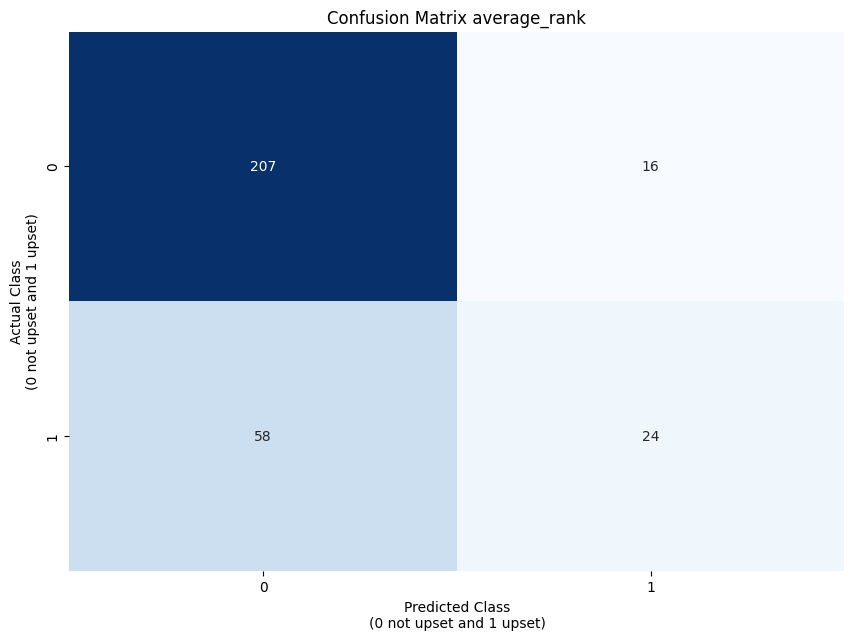

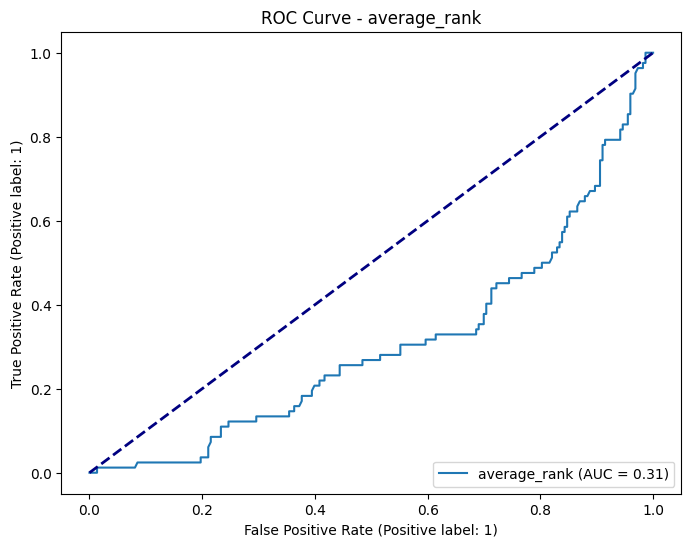

In [24]:
# Average Rank Aggregation
ratings_model = 'average_rank'
ratings_function = average_rank_aggregation
num_folds = 5

# Call ratings function and run cross validation
results = run_rating_models_cross_validation (fa_cup_scores_df, ratings_function, ratings_model, num_folds)

# Display results
display(results['predictions_df'])
display(results['upset_accuracy_scores_df'])
display(results['ratings_df'])
print(f"Mean Upset Accuracy: {results['mean_upset_accuracy']:.4f}")
print(f"Standard Deviation of Upset Accuracy: {results['std_upset_accuracy']:.4f}")

# Load predictions and ratinbgs to Google Big Query
predictions_df = results['predictions_df']
ratings_df = results['ratings_df']
load_predictions_and_ratings_to_bigquery(client, predictions_df, ratings_df, ratings_model)

# Create dataframe to compare rank and use for final rank aggregation
rank_df = ratings_df[['team_no', 'fold_number', 'rank']]
rank_df = rank_df.rename(columns={'rank': ratings_model})
all_ranks_df = all_ranks_df.merge(rank_df, on=['team_no','fold_number'], how='outer')
display(all_ranks_df)

print(results['all_actual_upsets'])
print(ratings_model)

# Create confusion matrix from results
results_df, cm_fig, roc_fig = create_model_results_df(results['all_actual_upsets'],results['all_predicted_upsets'], results['accuracies'], results['all_upset_probabilities'], ratings_model)
results_df = results_df.reset_index()
results_df['metric_id'] = results_df.index + 1
results_df = results_df[['metric_id', 'metric', ratings_model]]

all_results_df = all_results_df.merge(results_df, on=['metric_id', 'metric'], how='outer')
display(all_results_df)

In [25]:
# Load updated all ranks df to Big Query so Borda Count can be subsequently queried in local kemeny optimisation
load_dataset_name = 'analysis_layer'
load_table_name = 'ratings_model_ranks'
full_table_name = f"{load_dataset_name}.{load_table_name}"
pandas_gbq.to_gbq(all_ranks_df, full_table_name, project_id='birkbeck-msc-project-422917', if_exists='replace')

100%|██████████| 1/1 [00:00<00:00, 1451.32it/s]


In [26]:
# Local Kemeny Optimisation

def local_kemeny_optimisation (fold_number, max_iterations=10):

    def kendall_tau_distance(ranking1, ranking2):
        distance = 0
        for i in range(len(ranking1)):
            for j in range(i + 1, len(ranking1)):
                if (ranking1[i] < ranking1[j]) != (ranking2[i] < ranking2[j]):
                    distance += 1
        return distance

    def total_kendall_tau_distance(candidate, rankings):
        return sum(kendall_tau_distance(candidate, ranking) for ranking in rankings.values())

    def local_kemeny_optimisation(rankings, initial_ranking, max_iterations):
        n_items = len(initial_ranking)

        current_ranking = initial_ranking.copy()
        current_distance = total_kendall_tau_distance(current_ranking, rankings)

        for iteration in range(max_iterations):
            improved = False
            for i in range(n_items - 1):
                new_ranking = current_ranking.copy()
                new_ranking[i], new_ranking[i+1] = new_ranking[i+1], new_ranking[i]
                new_distance = total_kendall_tau_distance(new_ranking, rankings)

                if new_distance < current_distance:
                    current_ranking = new_ranking
                    current_distance = new_distance
                    improved = True
                    print(f"Iteration {iteration + 1}: Improved distance to {current_distance}")
                    break

            if not improved:
                print(f"Stopped after {iteration + 1} iterations: No improvement")
                break

        if iteration == max_iterations - 1:
            print(f"Stopped after reaching maximum iterations ({max_iterations})")

        return current_ranking

    # Authenticate using the loaded key
    #credentials = service_account.Credentials.from_service_account_info(key)
    # Set up the BigQuery client with the credentials to project
    client = bigquery.Client(credentials=credentials, project='birkbeck-msc-project-422917')

    # Query to get the data
    all_ranks_query = f"""
        SELECT * FROM analysis_layer.ratings_model_ranks WHERE fold_number = {fold_number}
    """

    all_ranks_df = client.query(all_ranks_query).to_dataframe()

    # Create dictionary of rankings
    rankings = {
        'basic_position': all_ranks_df['basic_position'].tolist(),
        'massey': all_ranks_df['massey'].tolist(),
        'colley': all_ranks_df['colley'].tolist(),
        'keener': all_ranks_df['keener'].tolist(),
        'trueskill': all_ranks_df['trueskill'].tolist()
    }

    # Use Borda count as initial ranking
    borda_count = all_ranks_df['borda_count'].tolist()

    # Perform local Kemeny optimization
    optimized_ranking = local_kemeny_optimisation(rankings, borda_count, max_iterations)
    print("\nTotal Kendall tau distance (Borda Count):", total_kendall_tau_distance(borda_count, rankings))
    print("Total Kendall tau distance (Optimized):", total_kendall_tau_distance(optimized_ranking, rankings))

    # Show which teams changed positions
    team_nos = all_ranks_df['team_no'].tolist()

    # Create a mapping from team number to rank for both rankings
    borda_mapping = {team: rank for rank, team in enumerate(borda_count)}
    optimized_mapping = {team: rank for rank, team in enumerate(optimized_ranking)}

    changes = []
    for team in team_nos:
        borda_rank = borda_mapping.get(team, -1)
        optimized_rank = optimized_mapping.get(team, -1)
        if borda_rank != optimized_rank:
            changes.append((team, borda_rank, optimized_rank))

    print("\nTeams that changed positions (Team, Old Position, New Position):")
    for change in changes:
        print(f"Team {change[0]}: {change[1]} -> {change[2]}")

    # Create a DataFrame with the optimized ranking
    optimized_df = pd.DataFrame({
        'team_no': team_nos,
        'overall_rank': optimized_ranking
    })

    # Calculate the rating based on the optimized ranking
    optimized_df['rating'] = 1 / optimized_df['overall_rank']

    # Create a list of tuples in the format (team_no, rating) for function
    ratings = list(zip(optimized_df['team_no'], optimized_df['rating']))

    return ratings


Fold 1/5
Train data size: 244
Test data size: 61
local_kemeny_optimisation
<function local_kemeny_optimisation at 0x7b6fd80d7760>
Iteration 1: Improved distance to 1143
Iteration 2: Improved distance to 1142
Iteration 3: Improved distance to 1141
Stopped after 4 iterations: No improvement

Total Kendall tau distance (Borda Count): 1144
Total Kendall tau distance (Optimized): 1141

Teams that changed positions (Team, Old Position, New Position):
Team 13: 13 -> 12
Team 14: 12 -> 13
Team 32: 32 -> 33
Team 35: 33 -> 32
Team 48: 56 -> 57
Team 49: 57 -> 56
[(1, 0.3333333333333333), (2, 0.2), (3, 1.0), (4, 0.5), (5, 0.25), (6, 0.125), (7, 0.03571428571428571), (8, 0.0625), (9, 0.16666666666666666), (10, 0.1111111111111111), (11, 0.058823529411764705), (12, 0.06666666666666667), (13, 0.07692307692307693), (14, 0.07142857142857142), (15, 0.1), (16, 0.034482758620689655), (17, 0.05555555555555555), (18, 0.05), (19, 0.027777777777777776), (20, 0.08333333333333333), (21, 0.025), (22, 0.03703703703

,ratings_model,fold_number,match_id,home_team_no,home_team_league_level,away_team_no,away_team_league_level,home_team_rating,away_team_rating,predicted_winner,actual_winner,actual_upset,predicted_upset,upset_probability
1,local_kemeny_optimisation,1,1428623,27,2,1,1,0.045455,0.333333,1,1,0,0,0.571477
2,local_kemeny_optimisation,1,957292,2,1,22,2,0.200000,0.037037,2,2,0,0,0.540651
3,local_kemeny_optimisation,1,846113,2,1,42,2,0.200000,0.025641,2,2,0,0,0.543480
4,local_kemeny_optimisation,1,192160,2,1,41,2,0.200000,0.043478,2,2,0,0,0.539051
5,local_kemeny_optimisation,1,883278,3,1,33,2,1.000000,0.028571,3,3,0,0,0.725404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,local_kemeny_optimisation,5,1349449,61,5,46,3,0.015873,0.052632,46,46,0,0,0.509189
302,local_kemeny_optimisation,5,472572,47,3,64,6,0.029412,0.016393,47,47,0,0,0.503255
303,local_kemeny_optimisation,5,846034,47,3,63,5,0.029412,0.016667,47,47,0,0,0.503186
304,local_kemeny_optimisation,5,475990,58,4,54,3,0.025641,0.020833,58,58,1,1,0.501202


,accuracy
1,0.754098
2,0.770492
3,0.786885
4,0.704918
5,0.803279


,ratings_model,fold_number,team_no,rating,rank
320,local_kemeny_optimisation,0,1,0.766667,1
0,local_kemeny_optimisation,1,1,0.333333,3
4,local_kemeny_optimisation,2,1,1.000000,1
2,local_kemeny_optimisation,3,1,0.500000,2
1,local_kemeny_optimisation,4,1,1.000000,1
...,...,...,...,...,...
317,local_kemeny_optimisation,1,64,0.015625,64
316,local_kemeny_optimisation,2,64,0.016129,62
318,local_kemeny_optimisation,3,64,0.015625,64
315,local_kemeny_optimisation,4,64,0.015873,63


Mean Upset Accuracy: 0.7639
Standard Deviation of Upset Accuracy: 0.0338
Big Query target predictions table analysis_layer.ratings_predictions rows deleted: 305
305 rows appended to predictions table analysis_layer.ratings_predictions successfully.
Big Query target ratings table analysis_layer.ratings rows deleted: 384
384 rows appended to ratings table analysis_layer.ratings successfully.


,team_no,fold_number,basic_position,massey,colley,keener,trueskill,borda_count,average_rank,local_kemeny_optimisation
0,1,0,1,1,1,12,1,1,1,1
1,1,1,1,1,3,14,1,3,3,3
2,1,2,1,1,1,13,1,1,1,1
3,1,3,1,1,2,10,2,2,2,2
4,1,4,1,1,1,12,1,2,2,1
...,...,...,...,...,...,...,...,...,...,...
379,64,1,64,59,64,54,62,64,64,64
380,64,2,64,53,63,56,59,62,62,62
381,64,3,64,59,64,54,62,64,64,64
382,64,4,64,57,63,60,61,63,63,63


,metric_id,metric,basic_position,massey,colley,keener,trueskill,borda_count,average_rank,local_kemeny_optimisation
0,1,Cross-validation Accuracy,0.731,0.708,0.702,0.725,0.708,0.757,0.757,0.764
1,2,Cross-validation Standard Deviation,0.008,0.028,0.048,0.028,0.050,0.046,0.046,0.034
2,3,Overall Accuracy,0.731,0.708,0.702,0.725,0.708,0.757,0.757,0.764
3,4,Confusion Matrix - True Negative (Class 0),223.000,192.000,186.000,199.000,181.000,207.000,207.000,209.000
4,5,Confusion Matrix - False Positive (Class 1),0.000,31.000,37.000,24.000,42.000,16.000,16.000,14.000
5,6,Confusion Matrix - False Negative (Class 0),82.000,58.000,54.000,60.000,47.000,58.000,58.000,58.000
6,7,Confusion Matrix - True Positive (Class 1),0.000,24.000,28.000,22.000,35.000,24.000,24.000,24.000
7,8,Precision (Class 0),0.731,0.768,0.775,0.768,0.794,0.781,0.781,0.783
8,9,Recall (Class 0),1.000,0.861,0.834,0.892,0.812,0.928,0.928,0.937
9,10,F1-score (Class 0),0.845,0.812,0.803,0.826,0.803,0.848,0.848,0.853


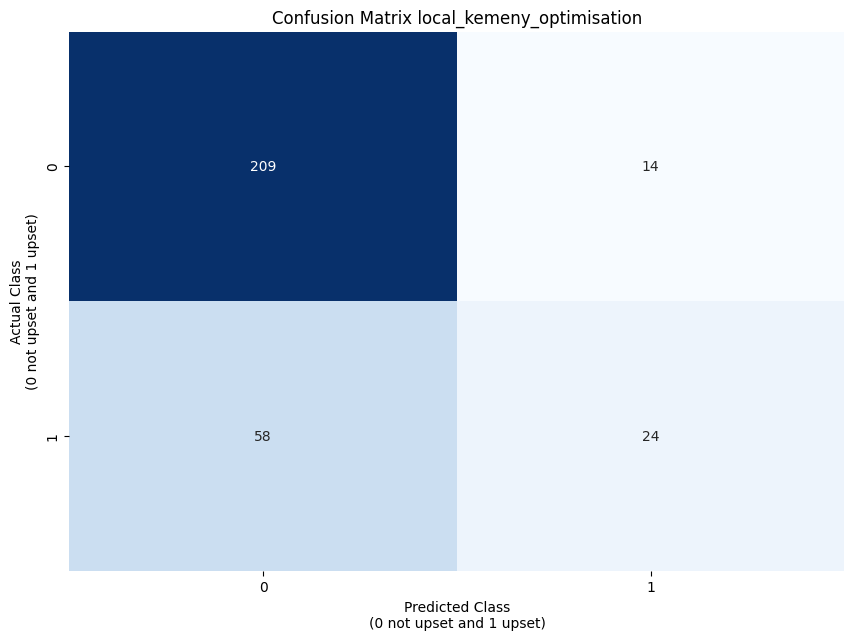

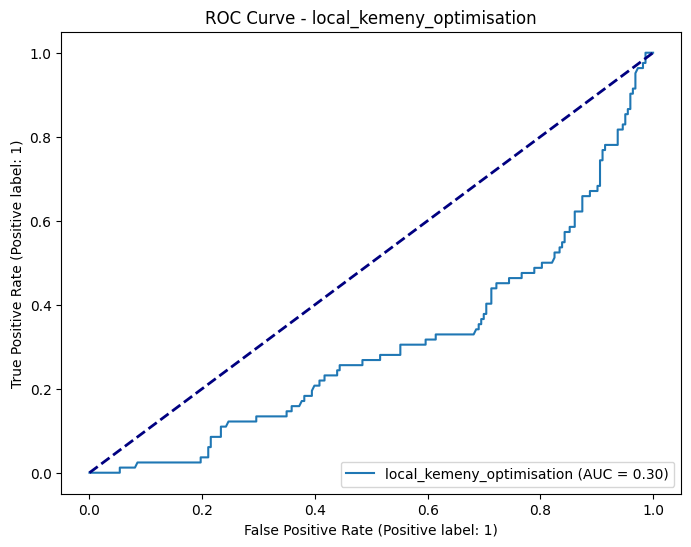

In [27]:
# Local Kemeny Optimisation

ratings_model = 'local_kemeny_optimisation'
ratings_function = local_kemeny_optimisation
num_folds = 5

# Call ratings function and run cross validation
results = run_rating_models_cross_validation (fa_cup_scores_df, ratings_function, ratings_model, num_folds)

# Display results
display(results['predictions_df'])
display(results['upset_accuracy_scores_df'])
display(results['ratings_df'])
print(f"Mean Upset Accuracy: {results['mean_upset_accuracy']:.4f}")
print(f"Standard Deviation of Upset Accuracy: {results['std_upset_accuracy']:.4f}")

# Load predictions and ratinbgs to Google Big Query
predictions_df = results['predictions_df']
ratings_df = results['ratings_df']
load_predictions_and_ratings_to_bigquery(client, predictions_df, ratings_df, ratings_model)

# Create dataframe to compare rank and use for final rank aggregation
rank_df = ratings_df[['team_no', 'fold_number', 'rank']]
rank_df = rank_df.rename(columns={'rank': ratings_model})
all_ranks_df = all_ranks_df.merge(rank_df, on=['team_no','fold_number'], how='outer')
display(all_ranks_df)

# Create confusion matrix from results
results_df, cm_fig, roc_fig = create_model_results_df(results['all_actual_upsets'],results['all_predicted_upsets'], results['accuracies'], results['all_upset_probabilities'], ratings_model)
results_df = results_df.reset_index()
results_df['metric_id'] = results_df.index + 1
results_df = results_df[['metric_id', 'metric', ratings_model]]

all_results_df = all_results_df.merge(results_df, on=['metric_id', 'metric'], how='outer')
display(all_results_df)

In [28]:
# Load final ranks including Local Kemeny Optimisation
load_dataset_name = 'analysis_layer'
load_table_name = 'ratings_model_ranks'
full_table_name = f"{load_dataset_name}.{load_table_name}"
pandas_gbq.to_gbq(all_ranks_df, full_table_name, project_id='birkbeck-msc-project-422917', if_exists='replace')

100%|██████████| 1/1 [00:00<00:00, 6223.00it/s]


In [32]:
# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df.to_excel("all_ranking_results.xlsx")